# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from tqdm  import tqdm

# load the dataset

In [2]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
# check cuda is available or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

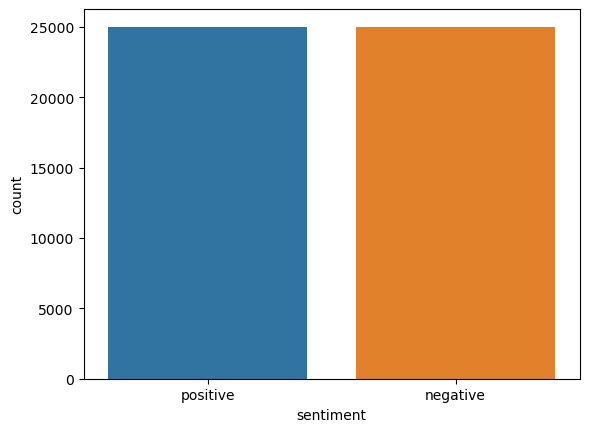

In [5]:
sns.countplot(x=df['sentiment'])

### split the data
We will split the data into train and test

In [6]:
X,y = df['review'].values,df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.20,random_state=42)
print(f'Shape of X train : {X_train.shape}\n Shape of x test : {X_test.shape}')


Shape of X train : (40000,)
 Shape of x test : (10000,)


## Tokenization

In [7]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def tokenize(x_train,x_test,y_train,y_test):
    word_list=[]
    stop_word =set(stopwords.words("english"))
    for sent in x_train:
        for word in sent.lower().split():
            word= preprocess_string(word)
            if word not in stop_word and word!='':
                word_list.append(word)
    
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict =  {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    final_list_train,final_list_test =[],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
        
          
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])    
    
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_test] 
    return np.array(final_list_train), np.array(final_list_test),np.array(encoded_train), np.array(encoded_test),onehot_dict

In [8]:
x_train, x_test, y_train, y_test, vocab = tokenize(X_train, X_test, y_train, y_test)

<built-in method get of Counter object at 0x72044fa02650>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
print(f"Length of Vocabalary : {len(vocab)}")

Length of Vocabalary : 1000


## Analyzing review length

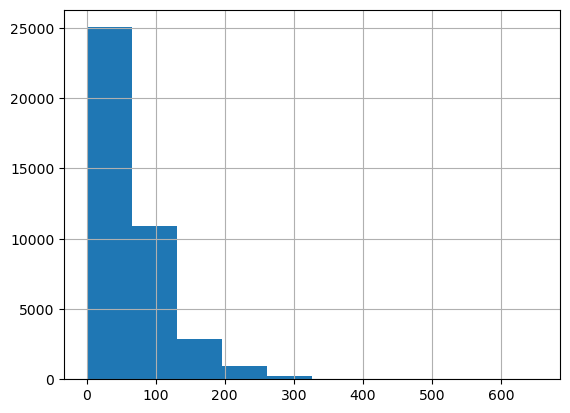

count    40000.000000
mean        69.170475
std         48.158105
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [10]:
review_length = [len(i) for i in x_train]
pd.Series(review_length).hist()
plt.show()
pd.Series(review_length).describe()

Observations :

a) Mean review length = around 69.

b) minimum length of reviews is 2.

c) There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

### Padding
Now we will pad each of the sequence to max length

In [11]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
        
    return features

In [12]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

### Batching and loading as tensor

In [13]:
# create tensor dataset
training_data = TensorDataset(torch.from_numpy(x_train_pad),torch.from_numpy(y_train))
testing_data = TensorDataset(torch.from_numpy(x_test_pad),torch.from_numpy(y_test))

#dataloader
batch_size=50
train_loader = DataLoader(training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(testing_data,shuffle=True,batch_size=batch_size)


In [14]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y =next( dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   4,  48, 223],
        [  0,   0,   0,  ...,  92,   1, 306],
        [  0,   0,   0,  ..., 326,   8,  16],
        ...,
        [  0,   0,   0,  ..., 135,  30,  18],
        [  0,   0,   0,  ...,  39,   1, 554],
        [  0,   0,   0,  ...,   1, 946,   1]])
Sample input: 
 tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1])


## Model Building

In [15]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=self.hidden_dim,
                           num_layers=no_layers,
                           batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
         # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embedding and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        
        hidden = (h0, c0)
        return hidden

In [16]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)


#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training

In [17]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [18]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_tst_loss = [],[]
epoch_tr_acc,epoch_tst_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    
    model.train()
    
    # initialize hidden state
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        
        output, h = model(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        
        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    test_h = model.init_hidden(batch_size)
    test_losses = []
    test_acc = 0.0
    
    model.eval()
    
    for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output, test_h = model(inputs, test_h)
        test_loss = criterion(output.squeeze(), labels.float())

        test_losses.append(test_loss.item())

        accuracy = acc(output,labels)
        test_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_test_loss = np.mean(test_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_test_acc = test_acc/len(test_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tst_loss.append(epoch_test_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_tst_acc.append(epoch_test_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_test_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_test_acc*100}')
    if epoch_test_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_test_loss))
        valid_loss_min = epoch_test_loss
    print(25*'==')

Epoch 1
train_loss : 0.5688498249650001 val_loss : 0.42844850093126297
train_accuracy : 69.655 val_accuracy : 80.91000000000001
Validation loss decreased (inf --> 0.428449).  Saving model ...
Epoch 2
train_loss : 0.39382951060310006 val_loss : 0.3590979988873005
train_accuracy : 82.87 val_accuracy : 83.95
Validation loss decreased (0.428449 --> 0.359098).  Saving model ...
Epoch 3
train_loss : 0.33553050274960694 val_loss : 0.3239480479806662
train_accuracy : 85.595 val_accuracy : 86.00999999999999
Validation loss decreased (0.359098 --> 0.323948).  Saving model ...
Epoch 4
train_loss : 0.3063820159528404 val_loss : 0.3239254622906447
train_accuracy : 87.065 val_accuracy : 85.87
Validation loss decreased (0.323948 --> 0.323925).  Saving model ...
Epoch 5
train_loss : 0.2777354960143566 val_loss : 0.33915040526539086
train_accuracy : 88.3575 val_accuracy : 85.83


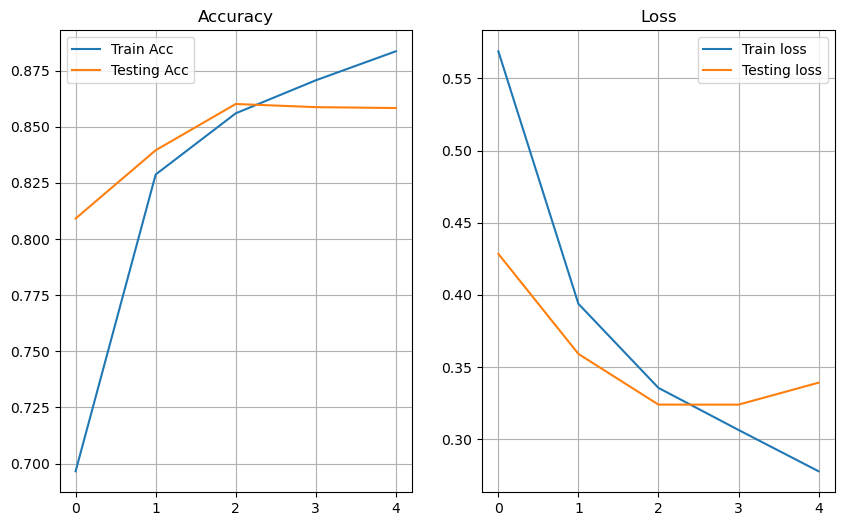

In [19]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_tst_acc, label='Testing Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_tst_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inference

In [20]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())